## Necessary libraries

In [1]:
import os
import sys

sys.path.append(os.path.abspath('..'))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# To ignore warnings
import warnings
from datetime import datetime
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    make_scorer,
    precision_score,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from utils.data import (
    preprocessing_cyclical_features,
    preprocessing_missing_values,
    temporal_split,
)
from utils.model import *

warnings.filterwarnings('ignore')

# Display settings for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Set random seed for reproducibility
np.random.seed(24)

## Load dataset ready for modeling

In [2]:
data_folder = Path('../data')
dataset = pd.read_csv(data_folder / 'dataset_for_modeling.csv')

dataset.head()

,Close,ln_volume_min,ln_volume_median,ln_volume_max,daily_growth_min,daily_growth_median,daily_growth_max,weekly_growth_min,weekly_growth_median,weekly_growth_max,biweekly_growth_min,biweekly_growth_median,biweekly_growth_max,monthly_growth_min,monthly_growth_median,monthly_growth_max,rel_spread_oc_median,rel_spread_hl_median,vol_10d_mean_median,vol_10d_std_median,vol_10d_min_median,vol_10d_max_median,return_1m,return_2m,return_3m,...,ticker_SHOP,ticker_TMUS,ticker_TSLA,sector_Communication Services,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Healthcare,sector_Technology,industry_Auto Manufacturers,industry_Beverages - Non-Alcoholic,industry_Communication Equipment,industry_Consumer Electronics,industry_Discount Stores,industry_Drug Manufacturers - General,industry_Entertainment,industry_Internet Content & Information,industry_Internet Retail,industry_Semiconductor Equipment & Materials,industry_Semiconductors,industry_Software - Application,industry_Software - Infrastructure,industry_Specialty Chemicals,industry_Telecom Services,is_positive_growth_3m_future,split
0,9.466013,19.354450,19.817254,20.264685,-0.060907,0.003425,0.035458,-0.034298,0.008902,0.068593,-0.024067,0.037035,0.099208,0.032941,0.120775,0.248355,-0.002655,0.031357,0.003951,0.025593,-0.035300,0.035458,0.070597,0.300408,0.441894,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,1,train
1,10.579280,19.400074,19.704151,20.112023,-0.040747,0.006489,0.034872,-0.035612,0.021164,0.102729,-0.036088,0.046778,0.137892,0.071931,0.115538,0.161729,-0.005839,0.028124,0.004828,0.022646,-0.035300,0.032364,0.117607,0.196506,0.453345,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,1,train
2,13.329807,19.313973,19.838280,20.723134,-0.028213,0.002897,0.066845,-0.033644,0.052272,0.130023,0.047523,0.092004,0.175115,0.065439,0.163070,0.259992,-0.002940,0.031985,0.009196,0.023863,-0.028213,0.054401,0.259992,0.408175,0.507589,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,train
3,13.489325,20.052498,20.364709,21.104222,-0.092775,0.009627,0.067321,-0.141829,0.002035,0.123525,-0.131252,-0.004512,0.182254,-0.046609,0.032518,0.278154,0.000403,0.049372,0.000284,0.040437,-0.056209,0.058182,0.011967,0.275070,0.425027,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,train
4,12.495856,19.207300,19.646596,20.480455,-0.057458,-0.007170,0.044422,-0.077721,0.006471,0.102567,-0.104166,0.033925,0.151789,-0.089517,0.088317,0.172165,0.007110,0.025488,0.003600,0.023737,-0.040563,0.042578,-0.073648,-0.062563,0.181163,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,train


In [3]:
# prepare data for modeling
X_train_valid, y_train_valid, X_test, y_test, scaler = data_split(dataset)

## Score some default models

In [4]:
dt = fit_decision_tree(X_train_valid, y_train_valid)
rf = fit_random_forest(X_train_valid, y_train_valid)
knn = fit_knn(X_train_valid, y_train_valid)

# demonstarte the return dt object
dt


,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,24
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [5]:
for clf in [dt, rf, knn]:
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__)
    print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
    print(classification_report(y_test, y_pred))
    print("-" * 24)
    get_predictions_correctness(y_test, y_pred, to_predict='is_positive_growth_3m_future')
    print("-" * 24)


DecisionTreeClassifier
Accuracy: 0.639
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       124
           1       0.64      0.35      0.45        92

    accuracy                           0.64       216
   macro avg       0.64      0.60      0.59       216
weighted avg       0.64      0.64      0.61       216

------------------------
Prediction column: is_positive_growth_3m_future
is_positive_growth_3m_future
1    138
0     78
Name: count, dtype: int64
is_positive_growth_3m_future
1    0.638889
0    0.361111
Name: count, dtype: float64
------------------------
[[106  18]
 [ 60  32]]
------------------------

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.85      0.73       124
           1       0.64      0.35      0.45        92

    accuracy                           0.64       216
   macro avg       0.64      0.60      0.59       216
weighted avg       0.64      0.64

## Tune the selected models with custom search space

In [6]:
best_model, best_model_name, best_params, best_metric = tune_and_select_best_classifier(
    X_train_valid, y_train_valid, X_test, y_test)

RandomForest best params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest test metric (precision): 0.625
Model saved to ../saved_models/model_randomforest_trainingDate_20250924.joblib


## Retrieve the stored model and visualize proba distribution per actual label

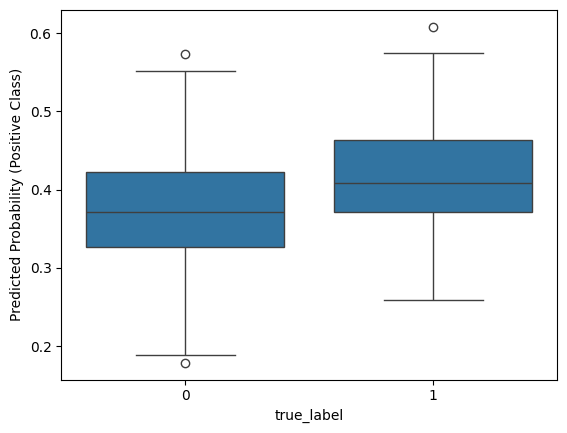

In [7]:
# Path to the saved model file (adjust as needed)
model_path = '../saved_models/model_randomforest_trainingDate_20250923.joblib'

# Load the model
best_model = joblib.load(model_path)

# Get probability estimates (for positive class, usually column 1)
proba = best_model.predict_proba(X_test)[:, 1]

# Inspect ground-truth labels for splitting
df_plot = pd.DataFrame({'probability': proba, 'true_label': y_test})
sns.boxplot(x='true_label', y='probability', data=df_plot)

plt.ylabel('Predicted Probability (Positive Class)')
plt.show()

In [8]:
# the precision score can be further optimized by adjusting the classification threshold
proba = best_model.predict_proba(X_test)[:, 1]
y_pred_custom_threshold = (proba >= 0.475).astype(int)
get_predictions_correctness(y_test, y_pred_custom_threshold, to_predict='is_positive_growth_3m_future')


Prediction column: is_positive_growth_3m_future
is_positive_growth_3m_future
1    136
0     80
Name: count, dtype: int64
is_positive_growth_3m_future
1    0.62963
0    0.37037
Name: count, dtype: float64
------------------------
[[116   8]
 [ 72  20]]
------------------------

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.94      0.74       124
           1       0.71      0.22      0.33        92

    accuracy                           0.63       216
   macro avg       0.67      0.58      0.54       216
weighted avg       0.66      0.63      0.57       216



In [9]:
# the precision score can be further optimized by adjusting the classification threshold
proba = best_model.predict_proba(X_test)[:, 1]
y_pred_custom_threshold = (proba >= 0.475).astype(int)
get_predictions_correctness(y_test, y_pred_custom_threshold, to_predict='is_positive_growth_3m_future')


Prediction column: is_positive_growth_3m_future
is_positive_growth_3m_future
1    136
0     80
Name: count, dtype: int64
is_positive_growth_3m_future
1    0.62963
0    0.37037
Name: count, dtype: float64
------------------------
[[116   8]
 [ 72  20]]
------------------------

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.94      0.74       124
           1       0.71      0.22      0.33        92

    accuracy                           0.63       216
   macro avg       0.67      0.58      0.54       216
weighted avg       0.66      0.63      0.57       216



In [10]:
print("That's all, folks!")

That's all, folks!
